# Calculate glacier terminus positions and terminus change rates at different dates
#### By Jukes Liu. Last modified 10-15-2019.

This notebook combines many outputs from different timepoints throughout the analysis to calculate terminus positions and terminus change rates through time. 

Files used:
    - Terminus box left midpoints and centerlines (Boxes_coords_pathrows.csv --> box_df)
    - Terminus chains picked by size (terminuspicks_size_yyyy_mm_dd.csv --> termini_df_s)
    - Terminus chains picked by mass (terminuspicks_mass_yyyy_mm_dd.csv --> termini_df_m)
    - DateTimes of satellite images (imgdates.csv --> datetime_df)
    - Glacier max speeds (Glacier_velocities.csv --> flowspeed_df)

### 1) Set up: Import packages, read in csv files

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.image as mpimg
import datetime
import types
import os
import cv2

basepath = '/home/jukes/Documents/Sample_glaciers/'

#set date for the terminus picks analyzed
d8 = '2019_10_02'

In [25]:
#Read in file with terminus box coordinates and centerlines
box_df = pd.read_csv(basepath+'Boxes_coords_pathrows.csv', sep=',', dtype=str)
box_df = box_df.set_index('BoxID')

#Read in files with terminus picks and drop those that have NaNs (no terminus line picked)
#size
termini_df_s = pd.read_csv(basepath+'terminuspicks_size_'+d8+'.csv', sep=',', dtype=str, usecols=[0,1,2,3,4], header=1)
termini_df_s = termini_df_s.dropna()
#mass
termini_df_m = pd.read_csv(basepath+'terminuspicks_mass_'+d8+'.csv', sep=',', dtype=str, usecols=[0,1,2,3,4], header=1)
termini_df_m = termini_df_m.dropna()

#Read in image dates
datetime_df = pd.read_csv(basepath+'datetags.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])

#Read in glacier velocity data
flowspeed_df= pd.read_csv(basepath+'Glacier_velocities.csv', sep=',', dtype=str, header=0, usecols=[1,2,3])
flowspeed_df = flowspeed_df.set_index('BoxID')

In [21]:
#look at the DataFrames
#Check number of rows for the termini_dfs:
print(termini_df_m.shape[0])

# box_df
# termini_df_m.head(10)
datetime_df.head()

3263


,Scene,datetimes
0,LC80360042017077LGN00,2017-03-18
1,LC80360042015248LGN00,2015-09-05
2,LC80360042015184LGN00,2015-07-03
3,LC80360042016107LGN00,2016-04-16
4,LC80360042015232LGN00,2015-08-20


### 2) Grab intersection of each terminus pick with the box centerline

Grab centerline slopes and intercepts from box_df (box coordinates file):

In [22]:
#FOR EACH BOX GRAB SLOPE AND INTERCEPT AS DICTIONARY WITH BOXID
slopes = {}
intercepts = {}

for index, row in box_df.iterrows():
#     if index == '004':
        #Grab centerline slope and intercept from the box_df
        slope = np.float(row['cline_slope'])
        intercept = np.float(row['cline_intercept'])
        slopes.update( {index: slope})
        intercepts.update( {index: intercept})
#         print(slope, intercept)

For each terminus line entry in termini_df_m or s, read in the .dat file and find the intersection point with the centerline (if there is an intersection at all):

In [9]:
#mass or size:
massorsize = 'mass'
# massorsize = 'size'
counter = 0

#hold intserection x and y coordinates and the index
indices = []
intersect_x = []
intersect_y = []

#Read in the dat files using BoxID, scene, and scale names:
for idx, rw in termini_df_m.iterrows():
# for idx, rw in termini_df_s.iterrows():
            BoxID = rw['BoxID']
            scene_name = rw['Scene']
            scale = rw['Scale']
            slope = np.float(slopes[BoxID])
            intercept = np.float(intercepts[BoxID])
            
            #grab each dat file corresponding to each terminus line entry
            datpath_base = '/media/jukes/jukes1/LS8aws/Box'+BoxID+"/rotated/resized/"
            datpath = datpath_base+"crop_R_"+scene_name+"_B8_PS_Buffer"+BoxID+".pgm_max_gaussian/terminus_highest"+massorsize+"/"
            final_dat_trim = datpath+"terminus_trim_"+scale+".dat"
            final_dat = datpath+"terminus_"+scale+".dat"
            
            #Read in dat file as np array and grab x and y values
            term_trim_dat = np.loadtxt(final_dat_trim)
            
            #Flag to stop the search when one centerline intersection is found (there might be multiple)         
            intersectfound = False
            
            #grab x and y values for the terminus line from the dat files
            for j in term_trim_dat:
                x, y = (int(j[0]), int(j[1]))
                
                #FOR EACH X VALUE IN THE DAT VALUE, CALCULATE THE CORRESPONDING CENTERLINE Y
                cline_y = int(slope*x + intercept)
                
                #IF THE Y-VALUE for the line correponds to this calculated centerline Y, this is the intersection point
                if intersectfound == False and cline_y == y:
                    print(idx, BoxID, scene_name, scale, x, y)
                    intersectfound = True
                    counter = counter+1
                    indices.append(idx)
                    intersect_x.append(x)
                    intersect_y.append(y)

OSError: /media/jukes/jukes1/LS8aws/Box001/rotated/resized/crop_R_LC80310052014242LGN00_B8_PS_Buffer001.pgm_max_gaussian/terminus_highestmass/terminus_trim_000.dat not found.

Add these intersection points back into the data frame by index:

In [5]:
intersections_df = pd.DataFrame(list(zip(indices, intersect_x, intersect_y)),
              columns=['index','Intersect_x','Intersect_y'])
intersections_df = intersections_df.set_index('index')
intersections_df.head(11)

,Intersect_x,Intersect_y
index,,
1,143,161
2,143,161
3,143,161
4,141,161
5,140,161
6,143,161
7,143,161
8,143,161
9,146,161


In [6]:
# #For mass
termini_df_m.index.name='index'
new_df = termini_df_m.merge(intersections_df, how= 'outer', on='index')

#For size
# termini_df_s.index.name='index'
# new_df = termini_df_s.merge(intersections_df, how= 'outer', on='index')

In [7]:
print(new_df.shape)
new_df.head(15)

(3263, 7)


,BoxID,Scene,Scale,Mass,Order,Intersect_x,Intersect_y
index,,,,,,,
1,001,LC80310052014242LGN00,000,1837.3024148393,4,143.0,161.0
2,001,LC80310052014242LGN00,002,3126.3611437028,3,143.0,161.0
3,001,LC80310052014242LGN00,003,3213.5711912179,2,143.0,161.0
4,001,LC80310052014242LGN00,020,3285.9529039998,1,141.0,161.0
5,001,LC80310052016152LGN00,026,2485.4565421714,1,140.0,161.0
6,001,LC80310052014226LGN00,000,2920.6270045333,3,143.0,161.0
7,001,LC80310052014226LGN00,002,2991.4421030595,2,143.0,161.0
8,001,LC80310052014226LGN00,003,3667.9432926433,1,143.0,161.0
9,001,LC80340052016109LGN00,000,3249.4745146466,2,146.0,161.0


### 3) Create DateTime objects for each analysis timepoint for plotting timeseries

In [23]:
#Turn datetimes from datetime_df into DateTime objects
#grab the datetime strings
datetimes = datetime_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
datetime_df['datetimes'] = datetime_objs
#datetime_df

#Merge the datetags into the termini_df dataframes:
dated_termini_df_m = new_df.merge(datetime_df, how = 'outer', on = 'Scene')
# dated_termini_df_s = new_df.merge(datetime_df, how = 'outer', on = 'Scene')

NameError: name 'new_df' is not defined

In [9]:
#MASS
print(dated_termini_df_m.shape)
dated_termini_df_m = dated_termini_df_m.dropna()
dated_termini_df_m

#SIZE
# print(dated_termini_df_s.shape)
# dated_termini_df_s = dated_termini_df_s.dropna()
# dated_termini_df_s

(4136, 8)


,BoxID,Scene,Scale,Mass,Order,Intersect_x,Intersect_y,datetimes
0,001,LC80310052014242LGN00,000,1837.3024148393,4,143.0,161.0,2014-08-30
1,001,LC80310052014242LGN00,002,3126.3611437028,3,143.0,161.0,2014-08-30
2,001,LC80310052014242LGN00,003,3213.5711912179,2,143.0,161.0,2014-08-30
3,001,LC80310052014242LGN00,020,3285.9529039998,1,141.0,161.0,2014-08-30
4,002,LC80310052014242LGN00,045,16021.1310752448,5,650.0,581.0,2014-08-30
5,002,LC80310052014242LGN00,046,16119.8966122854,4,649.0,581.0,2014-08-30
6,002,LC80310052014242LGN00,047,16359.6253340446,3,649.0,581.0,2014-08-30
7,002,LC80310052014242LGN00,048,16842.2065343964,2,648.0,581.0,2014-08-30
8,002,LC80310052014242LGN00,049,17278.3534328354,1,647.0,581.0,2014-08-30
9,004,LC80310052014242LGN00,009,13216.0169597083,5,655.0,606.0,2014-08-30


### 4) Calculate terminus positions and the terminus change rates

In [10]:
#create lists of the subset dataframes (by BoxID) to be concatenated back together at the end
subset_dfs_m = []
subset_dfs_s = []

#LOOP THROUGH AND PERFORM CALCULATIONS ON THE DATA FOR EACH BOXID
for BoxID in box_df.index:
#     if BoxID=='531':
        box_midpoint_x = np.float(box_df.loc[BoxID, 'midpoint_x'])
    #     print("Box"+BoxID, box_leftmost_x, box_midpoint_x)

        #subset the full DataFrames to just the Box of interest
        subset_df_m = dated_termini_df_m[dated_termini_df_m['BoxID'] == BoxID].copy()
#         subset_df_s = dated_termini_df_s[dated_termini_df_s['BoxID'] == BoxID].copy()

        #grab the centerline intersections as an array and convert to fooat
        centerline_x_m = np.array(subset_df_m.loc[:, 'Intersect_x'])
        centerline_x_m = centerline_x_m.astype(float)
#         centerline_x_s = np.array(subset_df_s.loc[:, 'Intersect_x'])
#         centerline_x_s = centerline_x_s.astype(float)

        #CALCULATE THE X DISTANCE between each centerline intersection and the midpoint of box
        xdist_midpoint_m = centerline_x_m - box_midpoint_x
#         xdist_midpoint_s = centerline_x_s - box_midpoint_x

        #add these xdistances to the subset array
        subset_df_m['term_position'] = xdist_midpoint_m*15
#         subset_df_s['term_position'] = xdist_midpoint_s*15

        #CALCULATE TERMINUS CHANGE RATE
        #sort the subset DataFrame by date of delineation from earliest to latest
        subset_df_m = subset_df_m.sort_values(by=['datetimes', 'Scene','Order'], ascending=True)
#         subset_df_s = subset_df_s.sort_values(by=['datetimes', 'Scene', 'Order'], ascending=True)

        #create lists to store terminus change rates
        changerates_m_forward = []
#         changerates_m_backward = []
#         changerates_s_forward = []

        earliestdate = list(subset_df_m['datetimes'])[0]
#         earliestdate = list(subset_df_s['datetimes'])[0]
#         lastindex = len(list(subset_df_m['datetimes']))-1
#         lastdate = list(subset_df_m['datetimes'])[lastindex]

        #For each entry in the subset DataFrame:       
        for i in range(0, len(subset_df_m.index)):
#         for i in range(0, len(subset_df_s.index)):
            #for the earliest date of analysis, forward change rate is NaN
            if list(subset_df_m['datetimes'])[i] == earliestdate:
                changerates_m_forward.append(np.NaN)
#             if list(subset_df_s['datetimes'])[i] == earliestdate:
#                 changerates_s_forward.append(np.NaN)
            #for the last date of analysis, backward change rate is NaN
#             elif list(subset_df_m['datetimes'])[i] == lastdate:
#                 changerates_m_backward.append(np.NaN)
            #for all other entries:
            else:
                #grab the date of the terminus position and the terminus position
                t_term_m = list(subset_df_m['datetimes'])[i]
                x_term_m = list(subset_df_m['term_position'])[i]
#                 t_term_s = list(subset_df_s['datetimes'])[i]
#                 x_term_s = list(subset_df_s['term_position'])[i]
                
                #grab the previous date and terminus position
                t_term_prev_m = list(subset_df_m['datetimes'])[i-1]
                x_term_prev_m = list(subset_df_m['term_position'])[i-1]
#                 t_term_prev_s = list(subset_df_s['datetimes'])[i-1]
#                 x_term_prev_s = list(subset_df_s['term_position'])[i-1]
    
#                 #grab the following date and terminus position
#                 t_term_next_m = list(subset_df_m['datetimes'])[i+1]
#                 x_term_next_m = list(subset_df_m['term_position'])[i+1]
                
                #FORWARD
                #if the dates are the same, keep going back until we find the previous date and use that
                #terminus position
                counter_f = 2
                while t_term_prev_m == t_term_m:
                    t_term_prev_m = list(subset_df_m['datetimes'])[i-counter_f]
                    x_term_prev_m = list(subset_df_m['term_position'])[i-counter_f]
#                 while t_term_prev_s == t_term_s:
#                     t_term_prev_s = list(subset_df_s['datetimes'])[i-counter_f]
#                     x_term_prev_s = list(subset_df_s['term_position'])[i-counter_f]
                    
                    
                    counter_f = counter_f+1
            
                #calculate the forward change in terminus position and the change in time
                deltax_m_f = x_term_m - x_term_prev_m
                deltat_m_f = t_term_m - t_term_prev_m
#                 deltax_s_f = x_term_s - x_term_prev_s
#                 deltat_s_f = t_term_s - t_term_prev_s
                
#                 #BACKWARD
#                 #if the dates are the same, keep going forward until we find the next date and use that
#                 #terminus position
#                 counter_b = 2
#                 while t_term_next_m == t_term_m:
#                     t_term_prev_m = list(subset_df_m['datetimes'])[i+counter_b]
#                     x_term_prev_m = list(subset_df_m['term_position'])[i+counter_b]
#                     counter_b = counter_b+1
                
#                 #calculate the backward change in terminus position and the change in time
#                 deltax_m_b = x_term_m - x_term_next_m
#                 deltat_m_b = t_term_m - t_term_next_m

                #CONVERT DELTAT OBJECTS INTO RAW DAYS
                deltat_m_f = deltat_m_f.days
#                 deltat_s_f = deltat_s_f.days
#                 deltat_m_b = deltat_m_b.days

                #calculate change rate in meters/day 
                term_changerate_m_f = deltax_m_f/deltat_m_f
#                 term_changerate_s_f = deltax_s_f/deltat_s_f
#                 term_changerate_m_b = deltax_m_b/deltat_m_b

                #add the change rate to the change rate list
                changerates_m_forward.append(term_changerate_m_f)
#                 changerates_s_forward.append(term_changerate_s_f)
#                 changerates_m_backward.append(term_changerate_m_b)

        #print the terminus change rates (m/d)
    #     for changerate in changerates_m:
    #         print("{0:.2f}".format(changerate_m), "m/d")

        #add the terminus change rates to the subset df!
        subset_df_m['changerates'] = changerates_m_forward
#         subset_df_s['changerates'] = changerates_s_forward
#         subset_df_m['changerates_b'] = changerates_m_backward
        #append the subset dfs to the subset dfs listS
        subset_dfs_m.append(subset_df_m)
#         subset_dfs_s.append(subset_df_s)

#RECOMBINE THE SUBSET DFs
xdist_df_m = pd.concat(subset_dfs_m)
xdist_df_m.head()
# xdist_df_s = pd.concat(subset_dfs_s)
# xdist_df_s

,BoxID,Scene,Scale,Mass,Order,Intersect_x,Intersect_y,datetimes,term_position,changerates
490,001,LC80330052013125LGN01,002,2381.2436063521,1,146.0,161.0,2013-05-05,435.0,NaN
489,001,LC80330052013125LGN01,001,2298.0863383170,2,146.0,161.0,2013-05-05,435.0,NaN
488,001,LC80330052013125LGN01,000,2253.0456554597,3,146.0,161.0,2013-05-05,435.0,NaN
499,001,LC80320052013134LGN03,049,825.2515552209,1,175.0,157.0,2013-05-14,870.0,48.333333
498,001,LC80320052013134LGN03,047,588.1496159168,2,170.0,158.0,2013-05-14,795.0,40.000000


## 5) Plot terminus position and terminus change timeseries per glacier

Must separate the dataframe into individual dataframes for each glacier.

In [13]:
#set dictionaries to call info in DataFrames for each individual BoxID
termini_bybox_m = {}
# termini_bybox_s = {}

#grab dataframe for each individual BoxID
for BoxID in box_df.index:
    #grab termini pick info for that BoxID
    termini_bybox_df_m = xdist_df_m[xdist_df_m['BoxID'] == BoxID].copy()
#     termini_bybox_df_s = xdist_df_s[xdist_df_s['BoxID'] == BoxID].copy()
    #update to dictionaries
    termini_bybox_m.update( {BoxID: termini_bybox_df_m} )
#     termini_bybox_s.update( {BoxID: termini_bybox_df_s} )

### Select the data for the glacier with the BoxID of interest (BOI) and drop those where terminus change rates are higher than 1.5X the max flow speed.

If the glacier is flowing at less than 1 m/d, we assign a flat max flow speed threshold of 2 m/d.

In [30]:
#SET BOX OF INTEREST (BOI) to plot
BOI = '531'
#grab df for BOI 
df_BOI_m = termini_bybox_m[BOI].sort_values(by=['datetimes', 'Scene','Order'], ascending=True)
# df_BOI_s = termini_bybox_s[BOI].sort_values(by=['datetimes', 'Scene', Order'], ascending=True)

#Look at just one 'Order' out of the 5
# firstpass = df_BOI_m[df_BOI_m['Order']=='2'].copy()

# #DROP THOSE POINTS WHERE TERMINUS CHANGE RATES ARE UNREALISTIC usign max flow speed from flowspeed_df
# max_flow = float(flowspeed_df['Max_speed'][BOI])
# if max_flow < 1.0:
#     flow_thresh = 2.0
# else:
#     flow_thresh = 1.5*max_flow
# df_BOI_m = df_BOI_m[df_BOI_m['changerates'] < flow_thresh]

df_BOI_m
# df_BOI_s = df_BOI_s[df_BOI_s['changerates'] < 25.0]
# df_BOI_s

NameError: name 'termini_bybox_m' is not defined

In [94]:
massorsize = "size"
metric = "terminus_highest"+massorsize+"/"
downloadpath = '/media/jukes/jukes1/LS8aws/'
imagepath = downloadpath+"Box"+BOI+"/rotated/resized/"

#### Re-calculate new terminus changerates: run this as many times as you want

In [89]:
# #RE-CALCULATE TERMINUS CHANGE RATE
# #sort the subset DataFrame by date of delineation from earliest to latest
# df_BOI_m = df_BOI_m.sort_values(by=['datetimes', 'Scene','Order'], ascending=True)
# # df_BOI_s = df_BOI_s.sort_values(by=['datetimes', 'Scene', 'Order'], ascending=True)

# #create lists to store terminus change rates
# changerates_m_forward = []
# #         changerates_m_backward = []
# # changerates_s_forward = []

# earliestdate = list(df_BOI_m['datetimes'])[0]
# # earliestdate = list(df_BOI_s['datetimes'])[0]
# #         lastindex = len(list(subset_df_m['datetimes']))-1
# #         lastdate = list(subset_df_m['datetimes'])[lastindex]

# #For each entry in the subset DataFrame:       
# for i in range(0, len(df_BOI_m.index)):  
# # for i in range(0, len(df_BOI_s.index)): 
#     #for the earliest date of analysis, forward change rate is NaN
#     if list(df_BOI_m['datetimes'])[i] == earliestdate:
#         changerates_m_forward.append(np.NaN)
# #     if list(df_BOI_s['datetimes'])[i] == earliestdate:
# #         changerates_s_forward.append(np.NaN)
#             #for the last date of analysis, backward change rate is NaN
# #             elif list(subset_df_m['datetimes'])[i] == lastdate:
# #                 changerates_m_backward.append(np.NaN)
#     #for all other entries:
#     else:
#         #grab the date of the terminus position and the terminus position
#         t_term_m = list(df_BOI_m['datetimes'])[i]
#         x_term_m = list(df_BOI_m['term_position'])[i]
# #         t_term_s = list(df_BOI_s['datetimes'])[i]
# #         x_term_s = list(df_BOI_s['term_position'])[i]
                
#         #grab the previous date and terminus position
#         t_term_prev_m = list(df_BOI_m['datetimes'])[i-1]
#         x_term_prev_m = list(df_BOI_m['term_position'])[i-1]
# #         t_term_prev_s = list(df_BOI_s['datetimes'])[i-1]
# #         x_term_prev_s = list(df_BOI_s['term_position'])[i-1]
                
#         #FORWARD
#         #if the dates are the same, keep going back until we find the previous date and use that
#         #terminus position
#         counter_f = 2
#         while t_term_prev_m == t_term_m:
#             t_term_prev_m = list(df_BOI_m['datetimes'])[i-counter_f]
#             x_term_prev_m = list(df_BOI_m['term_position'])[i-counter_f]
# #         while t_term_prev_s == t_term_s:
# #             t_term_prev_s = list(df_BOI_s['datetimes'])[i-counter_f]
# #             x_term_prev_s = list(df_BOI_s['term_position'])[i-counter_f]
            
#             counter_f = counter_f+1
            
#         #calculate the forward change in terminus position and the change in time
#         deltax_m_f = x_term_m - x_term_prev_m
#         deltat_m_f = t_term_m - t_term_prev_m
# #         deltax_s_f = x_term_s - x_term_prev_s
# #         deltat_s_f = t_term_s - t_term_prev_s
                
#         #CONVERT DELTAT OBJECTS INTO RAW DAYS
#         deltat_m_f = deltat_m_f.days
# #         deltat_s_f = deltat_s_f.days
# #       deltat_m_b = deltat_m_b.days

#         #calculate change rate in meters/day 
#         term_changerate_m_f = deltax_m_f/deltat_m_f
# #         term_changerate_s_f = deltax_s_f/deltat_s_f
# #       term_changerate_m_b = deltax_m_b/deltat_m_b

#         #add the change rate to the change rate list
#         changerates_m_forward.append(term_changerate_m_f)
# #         changerates_s_forward.append(term_changerate_s_f)
# #       changerates_m_backward.append(term_changerate_m_b)
    
# #add the terminus change rates to the subset df!
# df_BOI_m['changerates_new'] = changerates_m_forward
# # df_BOI_s['changerates_new'] = changerates_s_forward

In [90]:
# #GET RID OF THOSE WITH NEW TERMINUS CHANGE RATES > 30.0
# df_BOI_m = df_BOI_m[df_BOI_m['changerates_new'] < flow_thresh]
# df_BOI_m.head()
# # df_BOI_s = df_BOI_s[df_BOI_s['changerates_new'] < 25.0]
# # df_BOI_s.head()

,BoxID,Scene,Scale,Mass,Order,Intersect_x,Intersect_y,datetimes,term_position,changerates,changerates_new
3019,531,LC80090022013117LGN01,000,4215.5614788001,1,239.0,239.0,2013-04-27,1095.0,0.000000,0.00
3048,531,LC80120022013122LGN01,000,5180.1244897678,1,239.0,239.0,2013-05-02,1095.0,-22.500000,-22.50
2790,531,LC80080022013142LGN01,001,3857.3728217292,1,238.0,239.0,2013-05-22,1080.0,-14.166667,-0.75
2799,531,LC80130022013145LGN00,007,4117.0329597123,1,219.0,242.0,2013-05-25,795.0,-95.000000,-95.00
3122,531,LC80110022013147LGN00,004,3108.3558448327,3,219.0,242.0,2013-05-27,795.0,-180.000000,0.00


### Keep the highest order pick for each date of analysis

In [6]:
#ADJUST DATAFRAME TO ONLY KEEP THE HIGHEST ORDER LINE FOR EACH IMAGE AND EACH DATE
#grab all unique Scene names
scene_list = []
order_list = []

#FOR EACH SCENE, ONLY CHOOSE THE PICK WITH THE HIGHEST ORDER
for index, row in df_BOI_m.iterrows():
    first_index = index
# for index, row in df_BOI_s.iterrows():
    #if the new row's scene is the same as the already saved scene, skip it
    if row["Scene"] == scene and index != first_index:
        pass
    #else grab the dataframe
    else:
        scene = row['Scene']
        eachscene_df = df_BOI_m[df_BOI_m['Scene']==scene].copy()
#         eachscene_df = df_BOI_s[df_BOI_s['Scene']==scene].copy()
        #find the minimum order for each scene
        min_order = 5
        for idx, rw in eachscene_df.iterrows():  
            if int(rw['Order']) < min_order:
                min_order = int(row['Order'])
        scene_list.append(str(scene))
        order_list.append(str(min_order))
#         print(scene, min_order)

#zip the scenes and minimum orders into a dataframe:
min_order_df = pd.DataFrame(list(zip(scene_list, order_list)),columns=['Scene','Order'])
# min_order_df

#MERGE BACK TO THE DF_BOI_M
df_BOI_merged = df_BOI_m.merge(min_order_df, how='inner', on=['Scene', 'Order'])
# df_BOI_merged = df_BOI_s.merge(min_order_df, how='inner', on=['Scene', 'Order'])
df_BOI_merged

NameError: name 'df_BOI_m' is not defined

### Plot formatting code

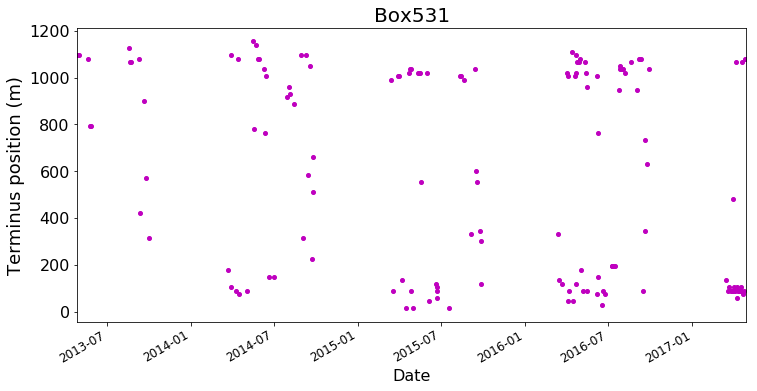

In [92]:
#PLOT TERMINUS POSITION 
ax = df_BOI_merged.plot(x='datetimes', y='term_position', color='m', marker='o', linestyle = 'None', figsize=(12,6), legend=None, markersize=4)
# ax = df_BOI_merged.plot(x='datetimes', y='term_position', color='c', marker='o', linestyle = 'None', figsize=(12,6), legend=None, markersize=4)
# firstpass.plot(x='datetimes', y='term_position', style='ko', ax=ax, legend=None, markersize=4)
# ax = firstpass.plot(x='datetimes', y='term_position', style='mo', figsize=(12,6), legend=None, markersize=4)
# df_BOI_s.plot(x='datetimes', y='xdist_midpoint', style='co-', ax=ax)
plt.ylabel('Terminus position (m)', fontsize=18)

# #PLOT TERMINUS CHANGE
# # drop any Nan values since they won't plot properly
# df_BOI_merged = df_BOI_merged.dropna()

# ax = df_BOI_merged.plot(x='datetimes', y='changerates', style='bo', figsize=(12,6), legend=None)
# plt.ylabel('Terminus change rate (m/d)', fontsize=18)

#PLOT PERCENT CLOUD
# df_BOI_m.Cloudpercent = df_BOI_m.Cloudpercent.astype(float)
# ax = df_BOI_m.plot(x='datetimes', y='Cloudpercent', style='co', figsize=(12,6), legend=None)
# plt.ylabel('% Cloud', fontsize=18)

#PLOT AVGPIXEL PERCENT
# df_BOI_m.Avgpixel_percent = df_BOI_m.Avgpixel_percent.astype(float)
# ax = df_BOI_m.plot(x='datetimes', y='Avgpixel_percent', style='ko', figsize=(12,6), legend=None)
# plt.ylabel('Avg pixel value (% of max)', fontsize=18)


#GENERAL PLOT PARAMETERS
plt.title("Box"+BOI, fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
# plt.legend(labels=['Mass' ,'Size'])
# plt.legend(labels=['Mass'])

#SAVE FIGURE
#MASS
plt.savefig(basepath+"/Figures/Termposition_LS8_m_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Termchangerates_LS8_m_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Cloudpercent_LS8_m_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Avgpixval_LS8_m_Box"+BOI+".png", dpi=200)

#SIZE
# plt.savefig(basepath+"/Figures/Termposition_LS8_s_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Termchangerates_LS8_s_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Cloudpercent_LS8_s_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Avgpixval_LS8_s_Box"+BOI+".png", dpi=200)

plt.show()

_Remnant code to plot terminus change values over the terminus position points:_

In [202]:
# #LABEL EACH POINT BY TERMINUS CHANGE RATE
# for i, changerate_m in enumerate(df_BOI_m.index):
# #     print(type(changerate), changerate)
#     #If the rate is a float (number or Nan), format it
#     if isinstance(changerate_m, float):
#         txt = str("{0:.2f}".format(changerate_m))
#         #If it's positive, add a + for clarity:
#         if changerate_m > 0:
#             txt = "+"+txt
#         #don't plot the nans
#         if np.isnan(changerate_m):
#             txt = " "
#     #for others, plot the string
#     else:
#         txt = str(changerate_m)
#     plt.annotate(txt, 
#                  xy=(list(df_BOI_m['datetimes'])[i] ,list(df_BOI_m['xdist_midpoint'])[i]), 
#                  fontsize=12,
#                  xytext=(6 ,4), 
#                  textcoords='offset points',
#                  color='m')
# for i, changerate_s in enumerate(df_BOI_s.index):
# #     print(type(changerate), changerate)
#     #If the rate is a float (number or Nan), format it
#     if isinstance(changerate_s, float):
#         txt = str("{0:.2f}".format(changerate_s))
#         #If it's positive, add a + for clarity:
#         if changerate_s > 0:
#             txt = "+"+txt
#         #don't plot the nans
#         if np.isnan(changerate_s):
#             txt = " "
#     #for others, plot the string
#     else:
#         txt = str(changerate_s)
#     plt.annotate(txt, 
#                  xy=(list(df_BOI_s['datetimes'])[i] ,list(df_BOI_s['xdist_midpoint'])[i]), 
#                  fontsize=12,
#                  xytext=(6 ,-10), 
#                  textcoords='offset points',
#                  color='c')

### Plot image and seglines

In [193]:
#add dat file x and ys in as dataframes:

#get list of images
print("Box"+BOI)
pathtoimgs = '/media/jukes/jukes1/LS8aws/Box'+BOI+'/rotated/resized/'
imgfiles = os.listdir(pathtoimgs)
images = []
term_dats = []
imgnames = []

for imgfile in imgfiles:
    #grab image files and append to images list
    if imgfile.endswith(BOI+".png"):
        print(imgfile)
        image = mpimg.imread(pathtoimgs+imgfile)
        
        #grab dat files
        pathtodat = pathtoimgs+imgfile[0:-4]+".pgm_max_gaussian/terminus_highestmass/"
        datfiles = os.listdir(pathtodat)
        
        #if there is a dat file:
        if len(datfiles) > 0:
            #grab the dat file and read it in and append to the list
            datfile = datfiles[0]
            print(datfile)
            term_dat = np.loadtxt(pathtodat+datfile)
            term_dats.append(term_dat)
            print(term_dat.shape)
            #append the image name
            images.append(image)
            imgnames.append(imgfile)
        else:
            print("NO DAT FILE FOUND")
            

print(len(term_dats), len(images))

Box001
crop_R_LC80340052015106LGN00_B8_PS_Buffer001.png
terminus_highestmass_016.dat
(50, 2)
crop_R_LC80340052015218LGN00_B8_PS_Buffer001.png
terminus_highestmass_013.dat
(59, 2)
crop_R_LC80340052015202LGN00_B8_PS_Buffer001.png
terminus_highestmass_019.dat
(79, 2)
crop_R_LC80340052013148LGN00_B8_PS_Buffer001.png
terminus_highestmass_007.dat
(59, 2)
crop_R_LC80340052017095LGN00_B8_PS_Buffer001.png
terminus_highestmass_008.dat
(119, 2)
crop_R_LC80340052014183LGN00_B8_PS_Buffer001.png
terminus_highestmass_017.dat
(27, 2)
crop_R_LC80340052015266LGN00_B8_PS_Buffer001.png
terminus_highestmass_014.dat
(74, 2)
crop_R_LC80340052016253LGN00_B8_PS_Buffer001.png
terminus_highestmass_049.dat
(43, 2)
crop_R_LC80340052015090LGN00_B8_PS_Buffer001.png
terminus_highestmass_032.dat
(55, 2)
crop_R_LC80340052014263LGN00_B8_PS_Buffer001.png
terminus_highestmass_048.dat
(41, 2)
crop_R_LC80340052015122LGN00_B8_PS_Buffer001.png
terminus_highestmass_048.dat
(41, 2)
crop_R_LC80340052016141LGN00_B8_PS_Buffer001.p

crop_R_LC80340052015202LGN00_B8_PS_Buffer001.png average pixel value: 0.28562254
crop_R_LC80340052017095LGN00_B8_PS_Buffer001.png average pixel value: 0.36437362
crop_R_LC80340052016125LGN00_B8_PS_Buffer001.png average pixel value: 0.21688671
crop_R_LC80340052016189LGN00_B8_PS_Buffer001.png average pixel value: 0.24517418
crop_R_LC80340052016205LGN00_B8_PS_Buffer001.png average pixel value: 0.25504142
crop_R_LC80340052016173LGN00_B8_PS_Buffer001.png average pixel value: 0.31532618
crop_R_LC80340052014247LGN00_B8_PS_Buffer001.png average pixel value: 0.3339636
crop_R_LC80340052015154LGN00_B8_PS_Buffer001.png average pixel value: 0.2765246
crop_R_LC80340052016157LGN00_B8_PS_Buffer001.png average pixel value: 0.27350658
crop_R_LC80340052016237LGN00_B8_PS_Buffer001.png average pixel value: 0.34981853
crop_R_LC80340052016221LGN00_B8_PS_Buffer001.png average pixel value: 0.26537254
Lines: 11


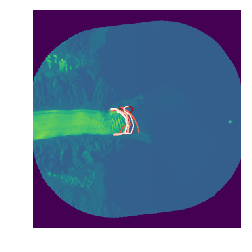

In [249]:
#imgplt = plt.imshow(images[40])
imgplt = plt.imshow(mpimg.imread('/home/jukes/Documents/Sample_glaciers/Box001/rotated_images/final/crop_PS_LC08_L1TP_031005_20180825_20180829_01_T1_B8_Buffer001cut.png'))
final_imgnames = []

xs = []
ys = []
for i in range(0, len(images)):
#     print(i)
    index = i
    #imgplt = plt.imshow(images[index])#cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB))\
    avgpxval = np.average(images[index])
   
    #if the pixel value is above a threshold, then grab the terminus
    if avgpxval < 0.37:
        final_imgnames.append(imgnames[index])
        print(imgnames[index], "average pixel value:", avgpxval)
        term = term_dats[index]
        term_xs = []
        term_ys = []

        #grab x and y values for the terminus line
        for j in term:
            x, y = (j[0], j[1])
            term_xs.append(x)
            term_ys.append(y)
        
        xs.append(term_xs)
        ys.append(term_ys)

#create dataframe with the term line coordinates and sort by date
termlines_df = pd.DataFrame(
    {'imgnames': final_imgnames,
     'X': xs,
     'Y': ys
    })

termlines_df = termlines_df.sort_values(by=['imgnames'])
termlines_df.head()

# #create reversed red color map for the lines
n=len(termlines_df.index)
print("Lines:", n)
colors = pl.cm.Reds_r(np.linspace(0,1,n))
col_count = 0

name = list(termlines_df['imgnames'])
x_final = list(termlines_df['X'])
y_final = list(termlines_df['Y'])

#plot each termline
for a in range(0, n):
    x, y = x_final[a], y_final[a]
    pl.plot(x, y, color=colors[col_count], linewidth=1)
    col_count = col_count+1

plt.axis("off")
plt.savefig(basepath+"/Figures/AGU2019_autolines_Box"+BOI+".png", dpi=300)

_Remnant code on plotting teminus changes:_

In [435]:
# #PLOT:
# plt.figure(figsize=(12, 8))
# plt.plot(changerates.keys(), changerates.values(),'rx', markersize=15)

# #Label the points by the change rate (m/d)
# for i, changerate in enumerate(changerates.values()):
#     txt = "{0:.2f}".format(changerate)
#     plt.annotate(txt, xy=(list(changerates.keys())[i], list(changerates.values())[i]), fontsize=16)

# plt.title("Box"+BOI, fontsize=20)
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Terminus change (m/d)', fontsize=18)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=16)
# plt.gca().invert_yaxis()

# plt.show()

#### Explore pick quality:

In [580]:
# print(df_BOI_m.shape)
# df_BOI_m.head()

In [581]:
# #list of datetimes associated with potentially bad picks 
# flag_dt = []
# termpositions = []
# termchangerates = []

# for index, row in df_BOI_m.iterrows():
#     date = row['datetimes']
#     scene = row['Scene']
#     cloudpercent = float(row['Cloudpercent'])
#     avgpixval = float(row['Avgpixel_percent'])
#     termposition = row['xdist_midpoint']
#     termchange = row['changerates']
    
#     if avgpixval > 40.0:
#         flag_dt.append(date)
#         termpositions.append(termposition)
#         termchangerates.append(termchange)
#         print(date, "flagged")

In [583]:
# print(termpositions)
# print(len(termpositions))

In [582]:
# badpick_clouds = []
# badpick_avgpix = []
# badpick_dates = []

# for index, row in df_BOI_m.iterrows():
#     date = row['datetimes']
#     scene = row['Scene']
#     cloudpercent = float(row['Cloudpercent'])
#     avgpixval = float(row['Avgpixel_percent'])
#     termposition = row['xdist_midpoint']
#     termchange = row['changerates']
    
#     if termposition < 500.0 or termposition > 1300.0: # or termchange > 100.0:
#         badpick_dates.append(date)
#         badpick_clouds.append(cloudpercent)
#         badpick_avgpix.append(avgpixval)
#         print(date, "flagged")

In [584]:
# print(badpick_avgpix)
# print(len(badpick_avgpix))
# # print(badpick_clouds)